## Deteksi Daun

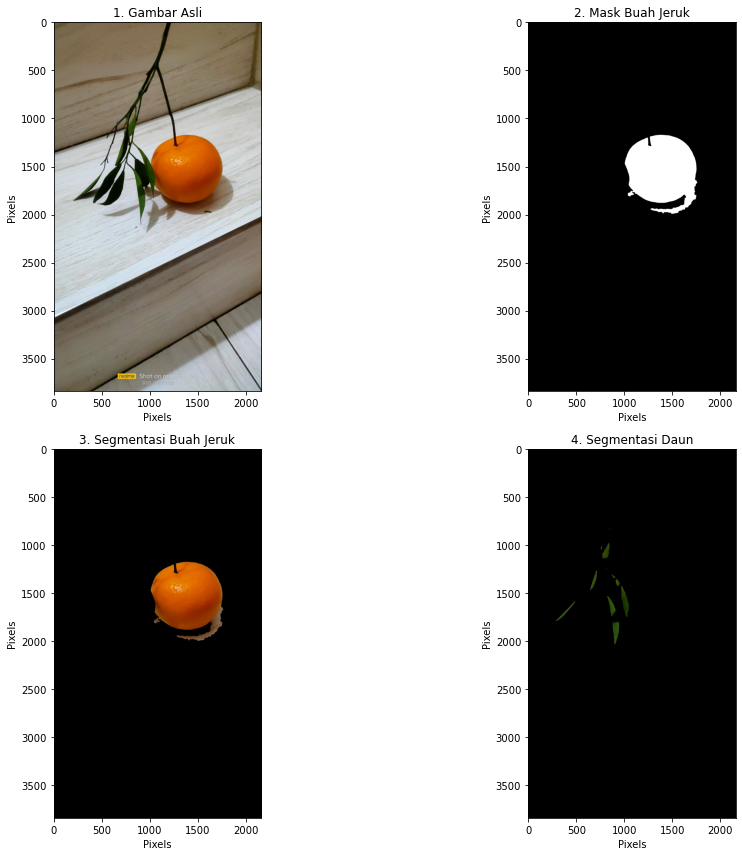

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('daun_buah_jeruk.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def enhanced_fruit_segmentation(img_rgb):
    # Convert to multiple color spaces
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    
    # Primary orange detection in HSV
    lower_orange1 = np.array([0, 100, 100])  # Extended lower range
    upper_orange1 = np.array([20, 255, 255])  # Extended upper range
    
    # Secondary range for deep orange
    lower_orange2 = np.array([5, 150, 150])
    upper_orange2 = np.array([15, 255, 255])
    
    mask1 = cv2.inRange(hsv, lower_orange1, upper_orange1)
    mask2 = cv2.inRange(hsv, lower_orange2, upper_orange2)
    hsv_mask = cv2.bitwise_or(mask1, mask2)
    
    # Use LAB space to remove shadows (B channel helps with shadow removal)
    b_channel = lab[:,:,2]
    _, lab_mask = cv2.threshold(b_channel, 145, 255, cv2.THRESH_BINARY)
    
    # Combine masks and remove shadows
    combined_mask = cv2.bitwise_and(hsv_mask, lab_mask)
    
    # Advanced morphological processing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Remove small noise while preserving fruit shape
    combined_mask = cv2.medianBlur(combined_mask, 5)
    
    # Find largest contour (assume it's the fruit)
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        final_mask = np.zeros_like(combined_mask)
        cv2.drawContours(final_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        return final_mask
    
    return combined_mask

def enhanced_leaf_segmentation(img_rgb):
    # Convert to HSV and LAB color spaces
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    
    # Green detection in HSV (with wider range)
    lower_green1 = np.array([25, 40, 40])
    upper_green1 = np.array([95, 255, 255])  # Extended upper range
    
    # Additional range for yellowish-green leaves
    lower_green2 = np.array([15, 40, 40])
    upper_green2 = np.array([25, 255, 255])
    
    mask1 = cv2.inRange(hsv, lower_green1, upper_green1)
    mask2 = cv2.inRange(hsv, lower_green2, upper_green2)
    leaves_mask = cv2.bitwise_or(mask1, mask2)
    
    # Use LAB space for better green detection (A channel)
    a_channel = lab[:,:,1]
    _, lab_mask = cv2.threshold(a_channel, 110, 255, cv2.THRESH_BINARY_INV)
    
    # Combine masks
    combined_mask = cv2.bitwise_and(leaves_mask, lab_mask)
    
    # Improved morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Fill small holes
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        cv2.drawContours(combined_mask, [cnt], 0, 255, -1)
    
    return combined_mask

# Segment both fruit and leaves
fruit_mask = enhanced_fruit_segmentation(image_rgb)
segmented_fruit = cv2.bitwise_and(image_rgb, image_rgb, mask=fruit_mask)

leaves_mask = enhanced_leaf_segmentation(image_rgb)
segmented_leaves = cv2.bitwise_and(image_rgb, image_rgb, mask=leaves_mask)

# Display results
plt.figure(figsize=(16, 12))

# 1. Original Image
plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title('1. Gambar Asli')
plt.xlabel('Pixels')
plt.ylabel('Pixels')

# 2. Fruit Mask
plt.subplot(2, 2, 2)
plt.imshow(fruit_mask, cmap='gray')
plt.title('2. Mask Buah Jeruk')
plt.xlabel('Pixels')
plt.ylabel('Pixels')

# 3. Segmented Fruit
plt.subplot(2, 2, 3)
plt.imshow(segmented_fruit)
plt.title('3. Segmentasi Buah Jeruk')
plt.xlabel('Pixels')
plt.ylabel('Pixels')

# 4. Segmented Leaves
plt.subplot(2, 2, 4)
plt.imshow(segmented_leaves)
plt.title('4. Segmentasi Daun')
plt.xlabel('Pixels')
plt.ylabel('Pixels')

plt.tight_layout()
plt.show()Z